In [4]:
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt
import pandas as pd
# dj.conn(host='vfsmdatajoint01.fsm.northwestern.edu', user='Santiago')
dj.conn()
dj.config['stores'] = {
    'raw': {
        'protocol':'file',
        'location':r'\\fsmresfiles.fsm.northwestern.edu\fsmresfiles\Ophthalmology\Research\SchwartzLab\Datajoint\raw',
    }
}
symphony = dj.create_virtual_module(module_name='symphony', schema_name='sln_symphony')
cells = dj.create_virtual_module(module_name='cells', schema_name='sln_cell')
cell_name = "092624Ac7"


In [5]:
my_cell = symphony.Experiment.Cell().proj(cell_name='concat(file_name, "c", cell_number)') & f'cell_name="{cell_name}"'
ds = symphony.Dataset() & my_cell & 'dataset_name LIKE "%SpatialNoise%"'
# ds = symphony.Dataset() & my_cell & 'dataset_name LIKE "%SpatialNoise_noShift%"'
ds

file_name,source_id,dataset_name
092624A,3,SpatialNoise_Whole_cell_Voltage_clamp


In [6]:
sn = symphony.Experiment.ProtSpatialNoiseV7bp() * \
    symphony.Experiment.ProtSpatialNoiseV7ep() * \
    (symphony.SpikeTrain() & (symphony.Dataset.Epoch() & ds) & 'channel_name="Amp1"')\
    * symphony.Experiment.Channel()\
    * symphony.Experiment.ProjectorSettings()
sn = sn * sn.proj(subsample_t='50')

sn_data = sn.fetch(as_dict = True)
np.save('092624Ac7_spatial_noise.npy',sn_data,allow_pickle=True)

In [7]:
pd.set_option('display.max_columns', None)  
df = pd.DataFrame(sn_data)
df

,file_name,source_id,epoch_group_id,epoch_block_id,epoch_id,channel_name,antialias,color_noise_mode,color_noise_distribution,frame_dwell,number_of_epochs,pre_time,resolution_x,resolution_y,rstar_mean,seed_change_mode,seed_start_value,size_x,size_y,stim_time,tail_time,contrast_1,contrast_2,mean_level_1,mean_level_2,subsample_x,subsample_y,offset_seed,noise_seed,spike_indices,spike_count,sample_rate,ndf,bit_depth,frame_rate,offset_x,offset_y,subsample_t
0,092624A,3,7,24,282,Amp1,T,1 pattern,gaussian,10,1,500.0,1,1,655.4,increment only,1,2000.0,2000.0,100000.0,500.0,1.0,0.0,0.1,0.0,1,1,4294967295,1,"[[5368, 5788, 6152, 6453, 6774, 7117, 7455, 77...",513,50000.0,3,8,60,-60,10,50
1,092624A,3,7,25,283,Amp1,T,1 pattern,gaussian,10,1,500.0,1,1,655.4,increment only,1,2000.0,2000.0,100000.0,500.0,1.0,0.0,0.1,0.0,1,1,4294967295,1,"[[16282, 33320, 37339, 47411, 73079, 85970, 92...",369,50000.0,3,8,60,-60,10,50


In [8]:
def getMovie(attrs):
    
    # noiseGen = np.random.Generator(np.random.MT19937(seed=int(attrs['noise_seed'])))
    # offsetGen = np.random.Generator(np.random.MT19937(seed=int(attrs['offset_seed'])))
    noiseGen = np.random.RandomState(seed=int(attrs['noise_seed']))
    offsetGen = np.random.RandomState(seed=int(attrs['offset_seed']))
    
    nFrames = int(attrs['frame_rate'] * (attrs['pre_time'] + attrs['stim_time'] + attrs['tail_time']) / 1000)
    preFrames = int(attrs['frame_rate'] * attrs['pre_time'] / 1000)

    res = (int(attrs['resolution_y']), int(attrs['resolution_x']))
    subsample = (int(attrs['subsample_y']), int(attrs['subsample_x']))

    # mov = np.empty((nFrames, *res))
    tmp = np.empty(res)
    mov = np.empty((nFrames, res[0]*subsample[0], res[1]*subsample[1]))

    ct = attrs['contrast_1'] * attrs['mean_level_1']

    if attrs['color_noise_distribution'] == 'binary':
        noiseFn = lambda x,y: 2 * (noiseGen.rand(x,y) > 0.5) - 1
    elif attrs['color_noise_distribution'] == 'gaussian':
        noiseFn = lambda x,y: noiseGen.randn(x,y)
    elif attrs['color_noise_distribution'] == 'uniform':
        noiseFn = lambda x,y: 2 * noiseGen.rand(x,y) - 1

    for frame in np.arange(nFrames):
        if frame  - preFrames < 0:
            mov[frame] = np.clip(attrs['mean_level_1'], 0.0, 1.0)
        elif frame % attrs['frame_dwell']:
            mov[frame] = mov[frame - 1]
        else:
            # mov[frame] = np.clip(attrs['meanLevel'] + ct * noiseFn(*res), 0.0, min(2*attrs['meanLevel'], 1.0))
            tmp = np.clip(attrs['mean_level_1'] + ct * noiseFn(*res), 0.0, min(2*attrs['mean_level_1'], 1.0))
            
            # p = np.asarray((offsetGen.randint(1,2*attrs['subsampleX'] - 1, 1) - attrs['subsampleX'], offsetGen.randint(1,2*attrs['subsampleY'] - 1, 1) - attrs['subsampleY'])).flatten()
            p = (np.ceil(offsetGen.rand()*(2*attrs['subsample_x'] - 1) - attrs['subsample_x']).astype(int), -np.ceil(offsetGen.rand()*(2*attrs['subsample_y'] - 1) - attrs['subsample_y']).astype(int))
            # print(p)
            # p = [p[0], -p[1]]
            # p = [0,0]

            # print(tmp.shape)
            # print(frame, p, np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:]).shape)

            mov[frame] = np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:])
            mov[frame] = np.roll(mov[frame], p[0], axis=0)
            mov[frame] = np.roll(mov[frame], p[1], axis=1)

            if p[0] >= 0:
                mov[frame,:p[0],:] = attrs['mean_level_1']
            else:
                mov[frame,p[0]:,:] = attrs['mean_level_1']
            
            if p[1] >= 0:
                mov[frame,:,:p[1]] = attrs['mean_level_1']
            else:
                mov[frame,:,p[1]:] = attrs['mean_level_1']
            
    return np.tile(mov[:,None, :, :], (1,attrs['subsample_t'], 1, 1)).reshape((-1, *mov.shape[1:]))

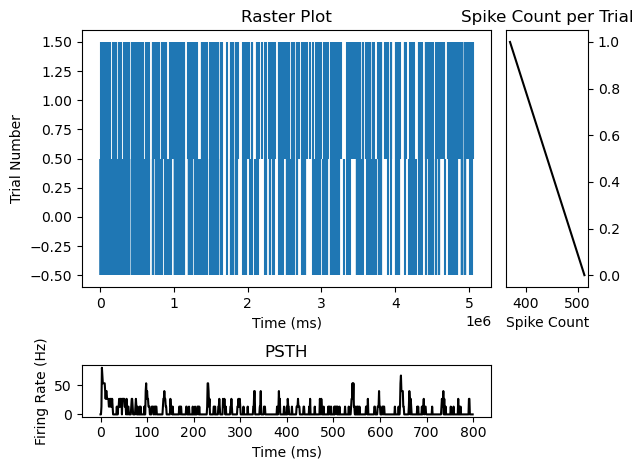

In [9]:

# Create the mosaic subplot layout
_, axs = plt.subplot_mosaic(
    '''
    ab
    c.
    ''', width_ratios=[5, 1], height_ratios=[5, 1])

# Raster plot
plt.sca(axs['a'])
for i, trial in enumerate(sn_data):
    plt.vlines(trial['spike_indices'].flatten(), i - .5, i + .5)  # Flatten in case spike_indices are not 1D
plt.xlabel('Time (ms)')
plt.ylabel('Trial Number')
plt.title('Raster Plot')

# Spike count per trial
plt.sca(axs['b'])
plt.plot([len(trial['spike_indices'].flatten()) for trial in sn_data], np.arange(len(sn_data)), 'k')
plt.xlabel('Spike Count')
plt.title('Spike Count per Trial')
axs['b'].yaxis.set_label_position("right")
axs['b'].yaxis.tick_right()

# PSTH
plt.sca(axs['c'])
duration = 30  # seconds
nbins = 800
bin_factor = nbins / duration

# Combine spike times from all trials and adjust for sample rate and bin factor
# Flatten each array to ensure they are 1D before concatenation
all_spike_times = np.concatenate([trial['spike_indices'].flatten() / trial['sample_rate'] for trial in sn_data])
psth, _ = np.histogram(all_spike_times * bin_factor, bins=nbins, range=(0, nbins))

# Normalize the PSTH by the number of trials and adjust for the bin factor to get firing rate
psth = psth / len(sn_data) * bin_factor
plt.plot(psth, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('PSTH')

plt.tight_layout()
plt.show()


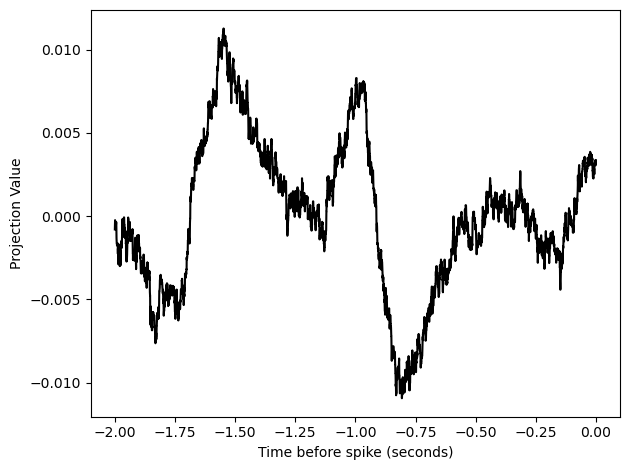

In [10]:
T = int(2*trial['frame_rate']* trial['subsample_t'])

sta = np.zeros((T, int(trial['resolution_y'] * trial['subsample_y']), int(trial['resolution_x'] * trial['subsample_x'])))
ns = np.zeros((T))

# for e in range(len(m)):

for trial in sn_data[:-1]:
    mov = getMovie(trial)
    fi = (trial['spike_indices'] * trial['frame_rate'] * trial['subsample_t'] // trial['sample_rate']).astype(int)
    fi = fi[fi>0]
    for f in fi:
        tt = min(T, f)
        sta[-tt:] += mov[f-tt:f]
        ns[-tt:] += 1 #number of spikes

sta = sta/ns[:,None,None]
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
mod = PCA(1)
pcs = mod.fit_transform(sta.reshape(T, -1))
# frames to time in seconds
frame_rate = trial['frame_rate']  # Assuming this is available from your data
time_in_seconds = (np.arange(T) - T) / (frame_rate * trial['subsample_t'] )
plt.plot(time_in_seconds, pcs, color='k')
plt.xlabel('Time before spike (seconds)')
plt.ylabel('Projection Value')
plt.axis('on')  
plt.tight_layout()
plt.show()

# Pre_time allignment

In [11]:

sn_data = sn.fetch(as_dict = True)
sn_data = pd.DataFrame.from_dict(sn_data)
sn_data['spike_indices'] = sn_data['spike_indices'].apply(lambda x: x[0] if isinstance(x, list) else x)
# # Explode spike_indices
sn_data = sn_data.explode('spike_indices').reset_index(drop=True)
# sn_data['spike_times'] = sn_data.apply(
#     lambda row: [(index / row['sample_rate']) + (row['pre_time'] / 1000.0) 
#                  for index in row['spike_indices']] if row['spike_indices'] is not None else None,
#     axis=1
# )

In [12]:
# Adjust spike times with pre_time and filter for those within stim_time
sn_data['spike_times'] = sn_data.apply(
    lambda row: [((index / row['sample_rate']) - (row['pre_time'] / 1000.0))
                 for index in row['spike_indices'] 
                 if (0 <= ((index / row['sample_rate']) - (row['pre_time'] / 1000.0)) <= (row['stim_time'] / 1000.0))]
                 if row['spike_indices'] is not None else None,
    axis=1
)

In [13]:
# Display all rows of the DataFrame
df = pd.DataFrame(sn_data)
df

,file_name,source_id,epoch_group_id,epoch_block_id,epoch_id,channel_name,antialias,color_noise_mode,color_noise_distribution,frame_dwell,number_of_epochs,pre_time,resolution_x,resolution_y,rstar_mean,seed_change_mode,seed_start_value,size_x,size_y,stim_time,tail_time,contrast_1,contrast_2,mean_level_1,mean_level_2,subsample_x,subsample_y,offset_seed,noise_seed,spike_indices,spike_count,sample_rate,ndf,bit_depth,frame_rate,offset_x,offset_y,subsample_t,spike_times
0,092624A,3,7,24,282,Amp1,T,1 pattern,gaussian,10,1,500.0,1,1,655.4,increment only,1,2000.0,2000.0,100000.0,500.0,1.0,0.0,0.1,0.0,1,1,4294967295,1,"[5368, 5788, 6152, 6453, 6774, 7117, 7455, 778...",513,50000.0,3,8,60,-60,10,50,"[0.009419999999999984, 0.024920000000000053, 0..."
1,092624A,3,7,25,283,Amp1,T,1 pattern,gaussian,10,1,500.0,1,1,655.4,increment only,1,2000.0,2000.0,100000.0,500.0,1.0,0.0,0.1,0.0,1,1,4294967295,1,"[16282, 33320, 37339, 47411, 73079, 85970, 926...",369,50000.0,3,8,60,-60,10,50,"[0.1664, 0.24678, 0.44821999999999995, 0.96158..."


In [14]:
trial = sn_data[0] 
 # Let's use the first trial as training data
mov = getMovie(trial)


KeyError: 0

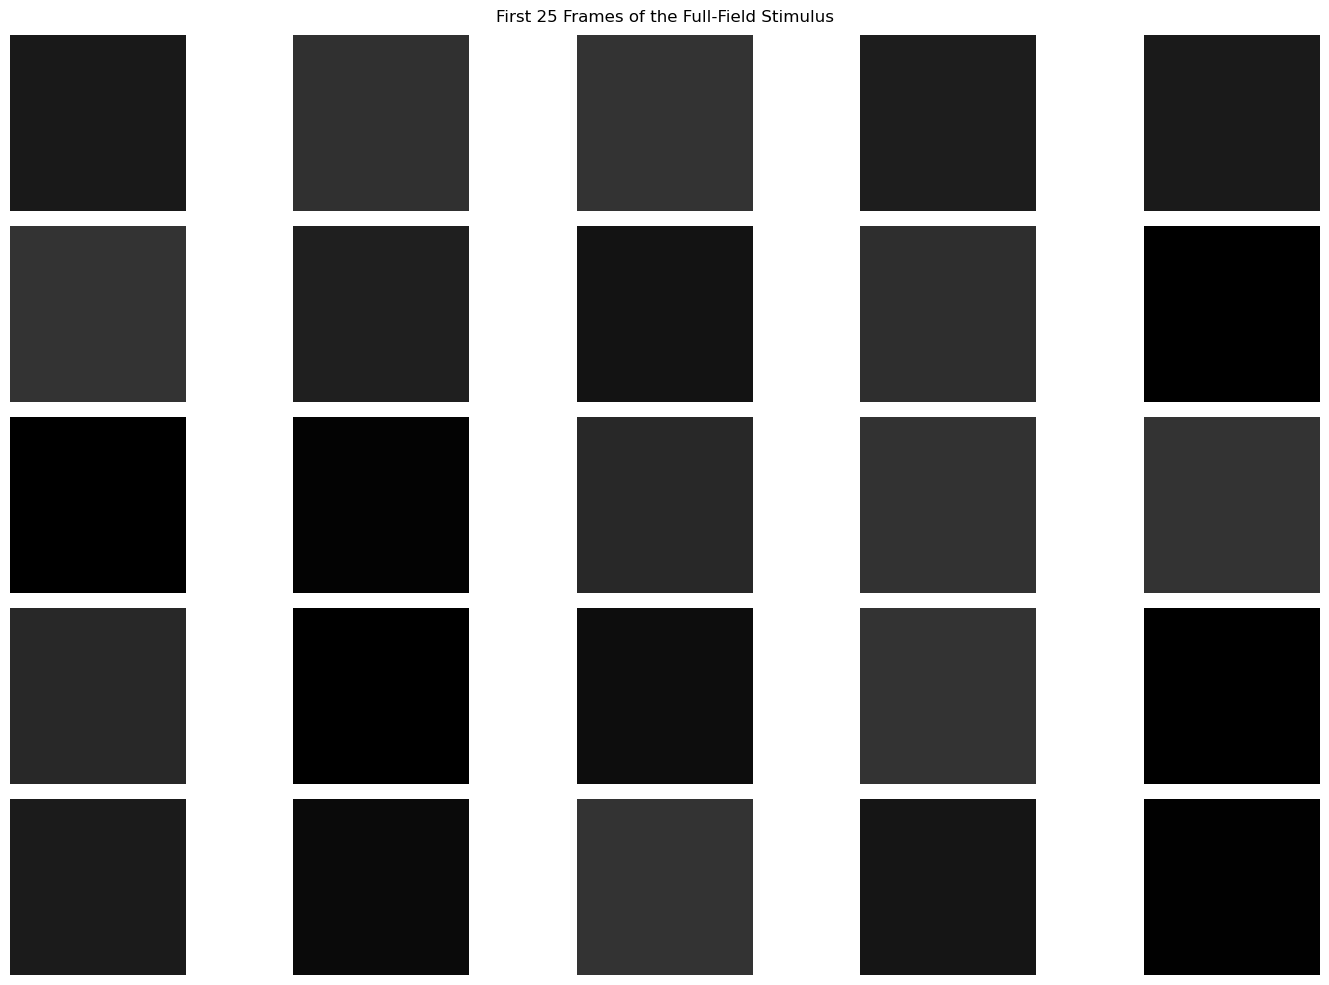

In [17]:
frame_size = (2000, 2000)
num_frames_to_show = 25
frame_indices = np.linspace(0, len(mov) - 1, num_frames_to_show).astype(int)
stim = []
# Plot the first 25 frames
plt.figure(figsize=(15, 10))
for i, frame_idx in enumerate(frame_indices):
    plt.subplot(5, 5, i + 1)
    
    frame_value = mov[frame_idx].squeeze()  # Get the scalar value of the frame
    stim.append(frame_value)
    frame_image = np.full(frame_size, frame_value)  # Create a full-field image
    
    plt.imshow(frame_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.suptitle("First 25 Frames of the Full-Field Stimulus")
plt.tight_layout()
plt.show()


In [12]:
trial = sn_data[1]
def vectors(mov,trial):
    spike_times = trial['spike_indices'].flatten()/trial['sample_rate']
    frame_rate = trial['frame_rate']
    dwell = trial['frame_dwell']
    stim = []

    for frame in np.arange(len(mov)):
        frame_value = mov[frame].squeeze()
        stim.append(frame_value)
    stim = np.array(stim)
    stim_times = np.arange(len(stim)) / (frame_rate*trial['subsample_t'])  # Time points for each frame
    stim_times = stim_times - trial['pre_time'] / 1000.0
    return stim, stim_times, spike_times


stim,stim_times,spike_times = vectors(mov,trial)
print(stim.shape)
print(stim_times.shape)
print(spike_times.shape)

(303000,)
(303000,)
(513,)


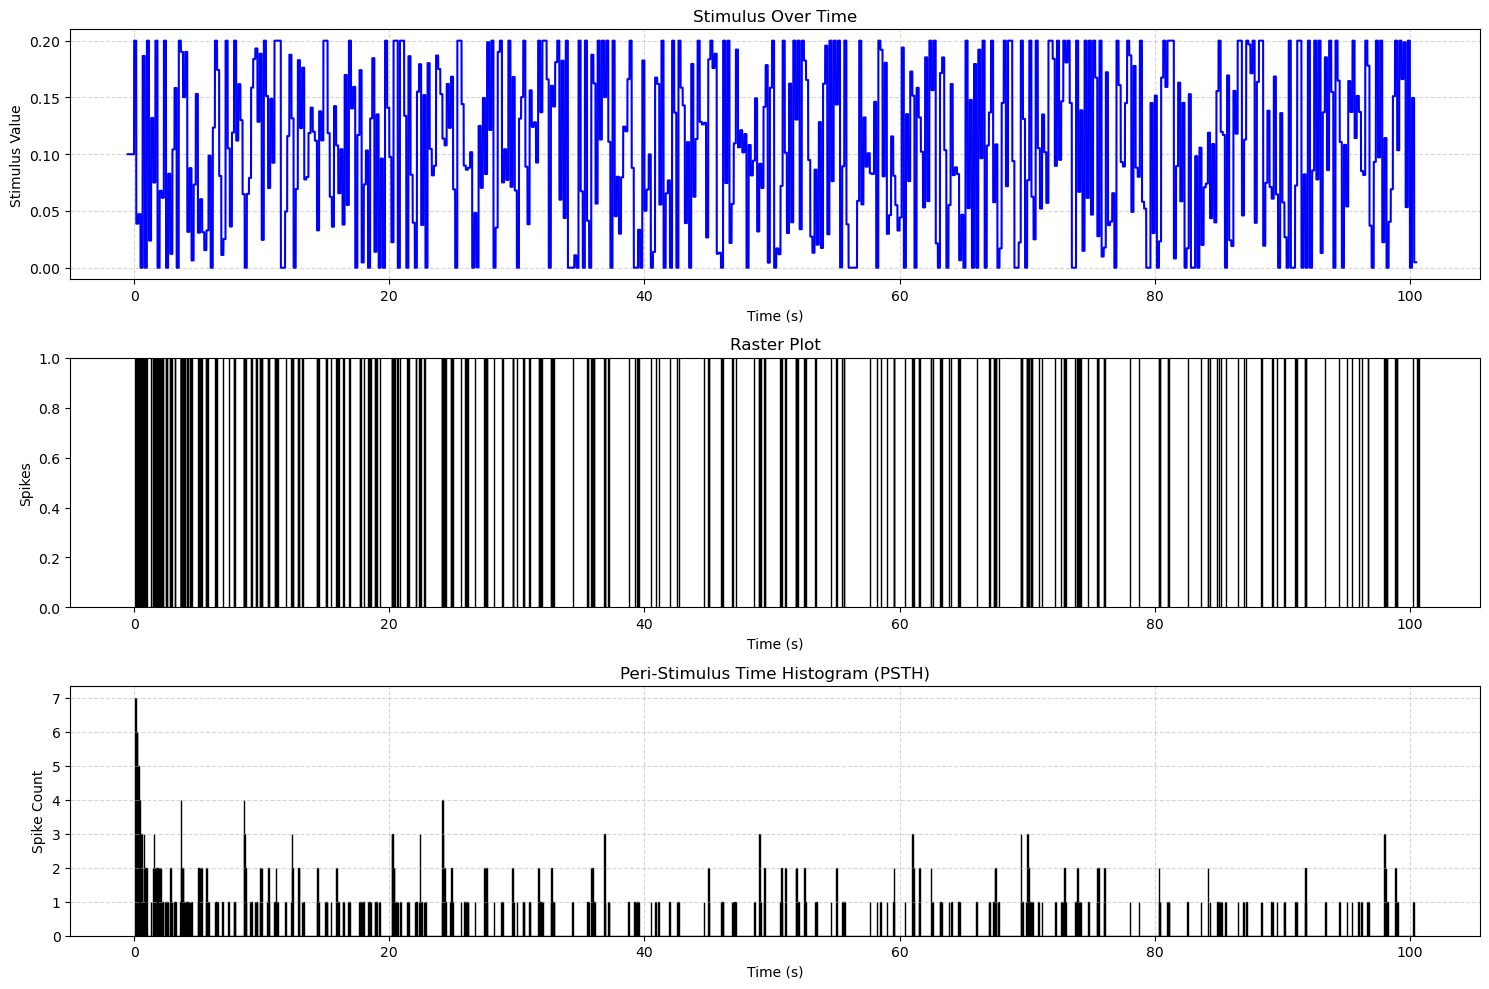

In [15]:
bin_width = 50/1000
bins = np.arange(0, stim_times[-1] + bin_width, bin_width)
psth, _ = np.histogram(spike_times, bins=bins)

psth_times = bins[:-1] + bin_width / 2
plt.figure(figsize=(15, 10))

# Common x-axis limits for alignment
x_limits = (-5, stim_times[-1]+5)

plt.subplot(3, 1, 1)
plt.plot(stim_times, stim, color='blue')
plt.xlim(x_limits)
plt.xlabel('Time (s)')
plt.ylabel('Stimulus Value')
plt.title('Stimulus Over Time')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(3, 1, 2)
for spike_time in spike_times:
    plt.axvline(spike_time, color='black', linestyle='-', linewidth=1)
plt.xlim(x_limits)
plt.xlabel('Time (s)')
plt.ylabel('Spikes')
plt.title('Raster Plot')

plt.subplot(3, 1, 3)
plt.bar(psth_times, psth, width=bin_width, color='grey', edgecolor='black')
plt.xlim(x_limits)
plt.xlabel('Time (s)')
plt.ylabel('Spike Count')
plt.title('Peri-Stimulus Time Histogram (PSTH)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

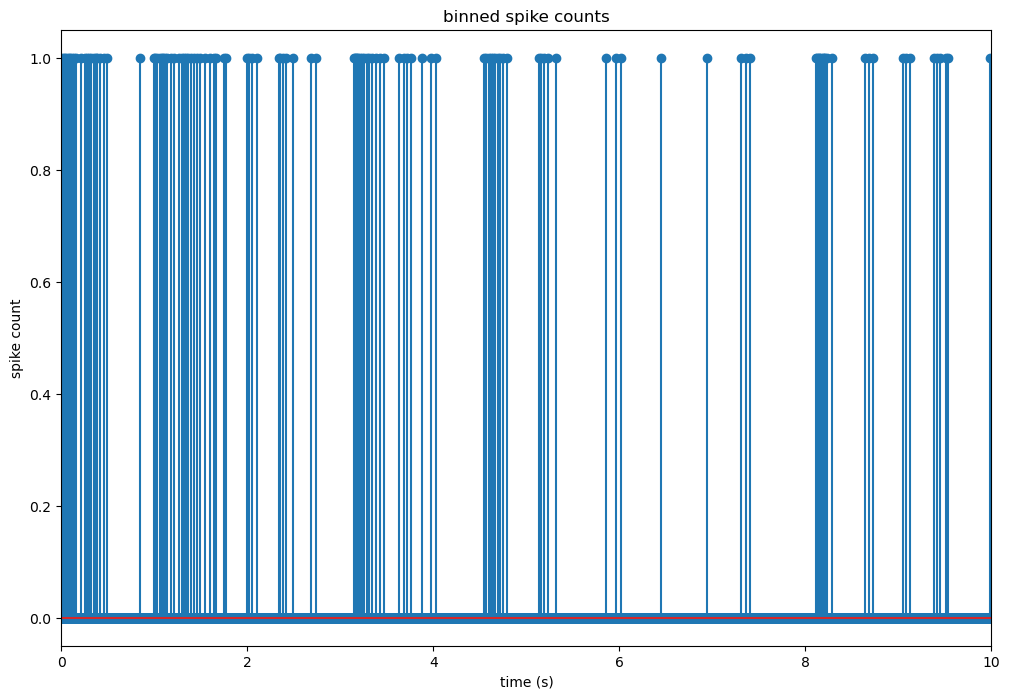

In [28]:
num_time_bins = stim.size # number of time bins in stimulus
dt_stim = stim_times[1] - stim_times[0]
spikes_bin_centers = np.arange(num_time_bins+1) * dt_stim # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

### Replot the responses we'll putting into our regression as counts
plt.clf()
plt.figure(figsize=[12,8])
plt.stem(stim_times,spikes_binned)
plt.title('binned spike counts')
plt.ylabel('spike count')
plt.xlabel('time (s)')
plt.xlim([0,10])
plt.show()